In [ ]:
# === Imports ===
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import time

# === Neural Field Attention Layer ===
from tensorflow.keras.layers import Layer

In [ ]:
# Load dataset
data = pd.read_csv("/content/dataset_full.csv")
print("Dataset shape:", data.shape)
print(data.head())

Dataset shape: (88647, 112)
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0            3               0                  0              1   
1            5               0                  1              3   
2            2               0                  0              1   
3            4               0                  2              5   
4            2               0                  0              0   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                     0              0           0            0   
1                     0              3           0            2   
2                     0              0           0            0   
3                     0              0           0            0   
4                     0              0           0            0   

   qty_exclamation_url  qty_space_url  ...  qty_ip_resolved  qty_nameservers  \
0                    0              0  ...                1                2   


In [ ]:
# Preprocessing
data = data.dropna().drop_duplicates()
boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params', 'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index', 'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)
numerical_columns = [col for col in data.columns if col not in boolean_columns]
scaler_standard = StandardScaler()
data[numerical_columns] = scaler_standard.fit_transform(data[numerical_columns])
scaler_minmax = MinMaxScaler()
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])
joblib.dump(scaler_standard, "scaler_standard.pkl")
joblib.dump(scaler_minmax, "scaler_minmax.pkl")
data.to_csv("newphishdata.csv", index=False)

In [ ]:
class NeuralFieldAttention(Layer):
    def __init__(self, timesteps=5, lambda_strength=0.2, **kwargs):
        super(NeuralFieldAttention, self).__init__(**kwargs)
        self.timesteps = timesteps
        self.lambda_strength = lambda_strength

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='interaction_kernel'
        )
        super(NeuralFieldAttention, self).build(input_shape)

    def call(self, inputs):
        I = inputs
        u = tf.zeros_like(I)
        for _ in range(self.timesteps):
            interaction = tf.matmul(I, self.kernel)
            activation = tf.nn.relu(u)
            delta = tf.reduce_mean(tf.abs(I - tf.reduce_mean(I, axis=1, keepdims=True)), axis=-1, keepdims=True)
            delta = tf.tile(delta, [1, 1, inputs.shape[-1]])
            u = u + (-u + interaction + I + self.lambda_strength * delta)
        attention_scores = tf.nn.softmax(u, axis=1)
        attended_output = tf.reduce_sum(attention_scores * inputs, axis=1)
        return attended_output

    def get_config(self):
        config = super(NeuralFieldAttention, self).get_config()
        config.update({
            'timesteps': self.timesteps,
            'lambda_strength': self.lambda_strength
        })
        return config

In [ ]:
# === Preprocessed Input ===
# Assuming X_train and y_train were already split from data
X_train_rnn = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# === Build RNN Model ===
model_rnn = Sequential()
model_rnn.add(LSTM(64, return_sequences=True, input_shape=(X_train_rnn.shape[1], 1)))
model_rnn.add(Dropout(0.2))
model_rnn.add(LSTM(32, return_sequences=True))  # Keep return_sequences for attention
model_rnn.add(Dropout(0.2))
model_rnn.add(NeuralFieldAttention(timesteps=5, lambda_strength=0.2))

# Dense Layers
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(32, activation='relu'))
model_rnn.add(Dropout(0.2))

# Output Layer
model_rnn.add(Dense(1, activation='sigmoid'))

In [ ]:
# === Compile Model ===
model_rnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
model_rnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 64, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neural_field_attention_3             │ (None, 32)                  │           1,024 │
│ (NeuralFieldAttention)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,561 (135.00 KB)

 Trainable params: 34,561 (135.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# === Callbacks ===
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
epoch_times = []

def on_epoch_begin(epoch, logs=None):
    global epoch_start_time
    epoch_start_time = time.time()

def on_epoch_end(epoch, logs=None):
    epoch_times.append(time.time() - epoch_start_time)
    print(f"Epoch {epoch+1} Time: {epoch_times[-1]:.2f}s")

time_callback = LambdaCallback(on_epoch_begin=on_epoch_begin, on_epoch_end=on_epoch_end)

In [ ]:
# === Train Model ===
history = model_rnn.fit(X_train_rnn, y_train,
                        validation_data=(X_test_rnn, y_test),
                        epochs=50,
                        batch_size=64,
                        callbacks=[early_stopping, time_callback],
                        verbose=1)

Epoch 1/50
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - AUC: 0.8793 - Precision: 0.7211 - Recall: 0.7760 - accuracy: 0.8204 - loss: 0.3750Epoch 1 Time: 122.13s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 122s 104ms/step - AUC: 0.8793 - Precision: 0.7211 - Recall: 0.7761 - accuracy: 0.8205 - loss: 0.3750 - val_AUC: 0.9360 - val_Precision: 0.7310 - val_Recall: 0.9744 - val_accuracy: 0.8657 - val_loss: 0.3030
Epoch 2/50
1090/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - AUC: 0.9231 - Precision: 0.7367 - Recall: 0.9522 - accuracy: 0.8630 - loss: 0.3070Epoch 2 Time: 111.77s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 112s 102ms/step - AUC: 0.9231 - Precision: 0.7367 - Recall: 0.9522 - accuracy: 0.8630 - loss: 0.3070 - val_AUC: 0.9391 - val_Precision: 0.7311 - val_Recall: 0.9744 - val_accuracy: 0.8657 - val_loss: 0.2901
Epoch 3/50
1090/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - AUC: 0.9266 - Precision: 0.7396 - Recall: 0.9366 - accuracy: 0.8627 - loss: 0.3023Epoch 3 Time: 113.21s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 113s 104ms/s

In [ ]:
# === Evaluate ===
y_pred = (model_rnn.predict(X_test_rnn) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# === Metrics ===
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

546/546 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step

Metrics:
Accuracy: 0.9086
Precision: 0.8564
Recall: 0.8872
AUC: 0.9036
Confusion Matrix:
[[10436   907]
 [  688  5411]]


In [ ]:
fp, fn = conf_matrix[0][1], conf_matrix[1][0]
tn, tp = conf_matrix[0][0], conf_matrix[1][1]
far = fp / (fp + tn)
frr = fn / (fn + tp)
print("\nFAR:", round(far, 4))
print("FRR:", round(frr, 4))


FAR: 0.08
FRR: 0.1128


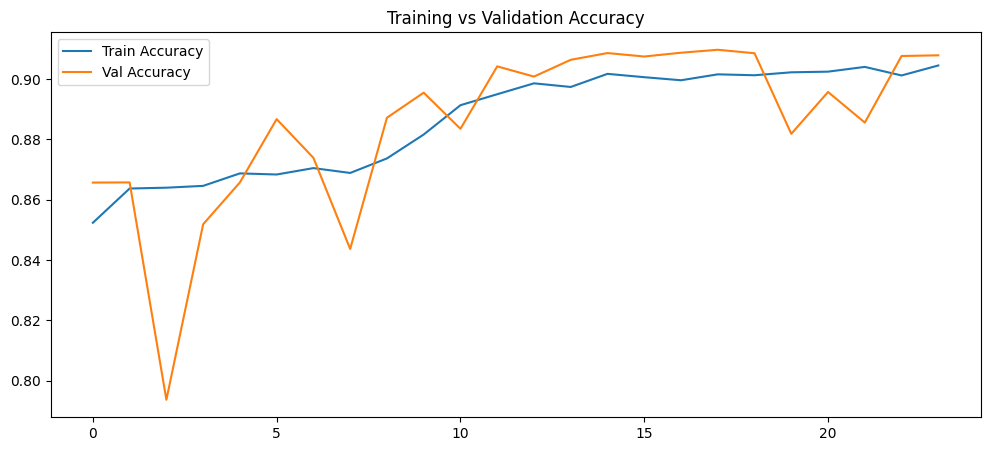

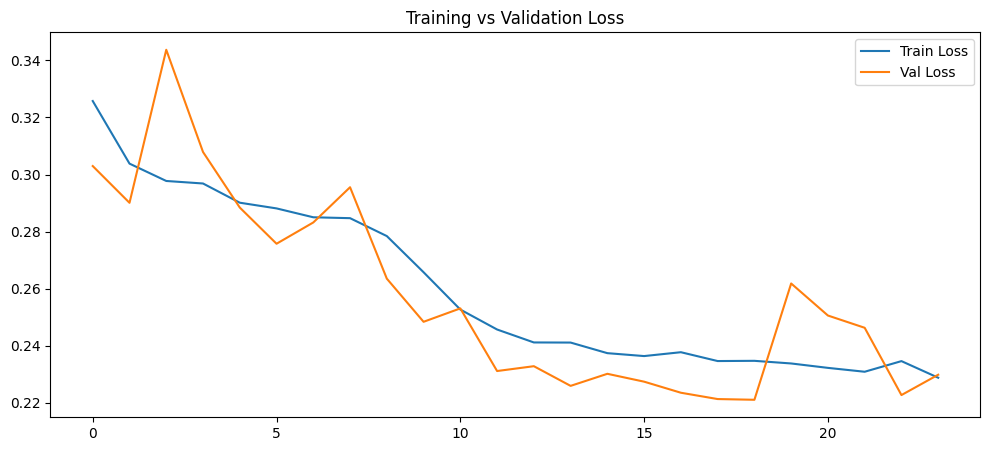

In [ ]:
# === Training Curves ===
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()